## Spotify Billboard 200 Second Impression

Refer to `bb200_first_impressions.ipynb` for the initial run-through and analysis of the features. In this notebook, we will quickly prepare the data for modeling in the same way we did in the first notebook, but perform some feature selection on our data. In the first notebook, we successfully fit a single decision tree with 75% cross-validated and out of sample accuracies; we will reuse its parameters during our feature selection process, try some over-under sampling, and then proceed to use AdaBoost to see if we can get additional predictive power through additive classifying trees. Then, by accessing the `feature_importances_` property of boosted tree classifiers, we examine which features are important, and hypothesize on the whys.

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, roc_curve, roc_auc_score
from imblearn.combine import SMOTEENN
sns.set()
%matplotlib inline

### Data preprocessing

As in `bb200_first_impressions.ipynb`, we first preprocess our data to deal with the missing values and standardize our continuous features.

**Remark.** Refer to `bb200_first_impressions.ipynb` for why exactly the code is as it is below.

In [3]:
# raw data
af_raw = pd.read_csv("./data/acoustic_features.csv")
# amend missing data
af_raw.iloc[241999, 3] = "Kenny G"
af_raw.loc[pd.isna(af_raw["artist"]), af_raw.columns == "artist"] = "Various Artists"
# create X and y; note that y is categorical now
X = af_raw.loc[:, af_raw.columns != "danceability"].dropna().copy()
y = pd.DataFrame(map(lambda x : 1 if x > 0.5 else 0, af_raw["danceability"].dropna()),
                columns = ["danceable"], index = X.index)
# standardize continuous features (we might want to run other models later)
cont_cols = ["acousticness", "duration_ms", "energy", "instrumentalness", "liveness", 
             "loudness", "speechiness", "tempo", "valence"]
# scale continuous columns and make new DataFrame out of them
sscl = StandardScaler()
Xs_cont = pd.DataFrame(sscl.fit_transform(X[cont_cols]), columns = cont_cols)
# get dummies for key and time_signature (mode is already 1 for major, 0 for minor)
# we ignore mode since mode is 1 for major, 0 for minor
cat_cols = ["key", "time_signature"]
# get dummies for each of the columns; need to map to string to be treated as categorical
X_cat = None
for cc in cat_cols:
    ccat = pd.get_dummies(pd.DataFrame(map(lambda x: str(int(x)), X[cc]), columns = [cc]), 
                          prefix = cc[:3])
    if X_cat is None: X_cat = ccat
    else: X_cat = X_cat.merge(ccat, how = "outer", left_index = True, right_index = True)
# merge standardized continuous features with categorical features
X = Xs_cont.merge(X_cat, how = "outer", left_index = True, right_index = True)
# check shapes of X, y
print("X shape: {0}\ty shape: {1}".format(X.shape, y.shape))
# preview X
X.head()

X shape: (339850, 26)	y shape: (339850, 1)


,acousticness,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key_0,...,key_5,key_6,key_7,key_8,key_9,tim_0,tim_1,tim_3,tim_4,tim_5
0,-0.771097,-0.923511,0.189653,-0.406136,-0.615265,0.600249,2.594201,-0.978872,-1.181590,0,...,0,1,0,0,0,0,0,0,1,0
1,-0.021569,-0.820553,-0.814268,-0.406136,-0.592036,0.002556,0.507205,0.200423,-0.522012,0,...,0,0,1,0,0,0,0,0,1,0
2,-0.462095,-0.209574,-0.666753,-0.405946,-0.545580,0.013206,0.266696,-1.002308,-1.225035,0,...,0,0,0,1,0,0,0,0,1,0
3,-0.898500,-0.462059,0.185556,-0.406136,-0.568808,0.833240,1.632166,-0.885787,-0.285038,0,...,0,0,0,0,1,0,0,0,1,0
4,-0.872513,-0.429865,0.021650,-0.406136,-0.382983,0.960603,0.313246,2.371132,-0.000669,0,...,0,1,0,0,0,0,0,0,1,0


Now we are ready to do some cross-validated feature selection using the same decision tree we tuned in `bb200_fist_impressions.ipynb`. We will first save the full data matrix for future analyses so we don't have to rerun everything again.

**Remark.** `X` is kind of large, so please wait a few seconds for the cell below to finish running.

In [102]:
X.to_csv("./data/X_full.csv", index = False)

### CV feature selection: decision tree

We tuned the decision tree already, so we will use the same hyperparameters and instead focus on selecting features. As usual, we do an 80-20 training and test split, and cross-validate on the training portion to select our features before reporting test performance. Again, we choose accuracy as the criterion, and perform 5-fold cross-validation on our training data during our feature selection.

**Remark.** The entire feature selection process takes around ~2 minutes on my machine, using 2 cores. Runtime/feature selection results may vary.

In [69]:
# create tuned decision tree and RFECV objects with 5-fold CV
dtc = DecisionTreeClassifier(criterion = "entropy", max_depth = 25, max_features = "auto",
                             min_samples_split = 40)
dtc_rfecv = RFECV(dtc, cv = 5, scoring = "accuracy", verbose = 1, n_jobs = 2)
# 80/20 train test split and feature selection on the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)
dtc_rfecv.fit(X_train, y_train)

c:\users\d\start\python3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.


RFECV(cv=5,
      estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy',
                                       max_depth=25, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=40,
                                       min_weight_fraction_leaf=0.0,
                                       presort=False, random_state=None,
                                       splitter='best'),
      min_features_to_select=1, n_jobs=2, scoring='accuracy', step=1,
      verbose=1)

Now that we have pruned our feature matrix, let's see which features were selected during feature elimination, and how many of them we have.

In [72]:
sfdf = X.columns[dtc_rfecv.support_]
print("{0}\n{1} selected features".format(sfdf, len(sfdf)))

Index(['acousticness', 'duration_ms', 'energy', 'instrumentalness', 'liveness',
       'loudness', 'speechiness', 'tempo', 'valence', 'tim_4'],
      dtype='object')
10 selected features


We have thus gone from 26 features to 10 features. Interestingly, most of our categorical features have been dropped. Let us check our cross-validated training and our holdout test accuracies to see if there is any meaningful difference between the two.

In [73]:
print("train accuracy:\t{0:.5f}\ntest accuracy:\t{1:.5f}".format(dtc_rfecv.score(X_train, y_train), 
                                                                 dtc_rfecv.score(X_test, y_test)))

train accuracy:	0.84683
test accuracy:	0.75479


Hm, it looks like our tree has overfit a lot more than we have liked it to, as we have nearly a 10% decrease in accuracy on the test data. It appears that preselecting features in this manner serves only to help the model to overfit, as there is no noticeable gain in test accuracy. Let us look at some other metrics such as misclassification rates, precision, AUC, and ROC curve for a more holistic picture of performance, as well as feature importances.

misclassification rate for 0:	0.32937
misclassification rate for 1:	0.18993
best tree test precision:	0.78923
best tree test AUC:		0.74035


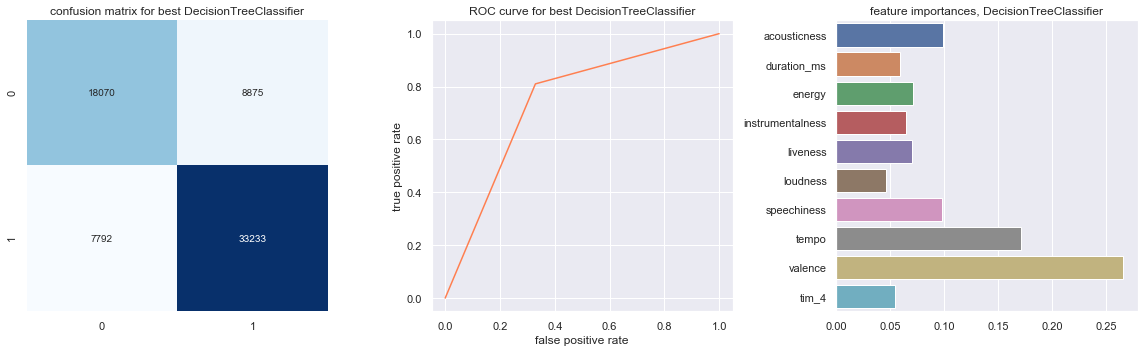

In [74]:
cmat = confusion_matrix(y_test, dtc_rfecv.predict(X_test))
print("misclassification rate for 0:\t{0:.5f}\nmisclassification rate for 1:\t{1:.5f}"
      "".format(cmat[0][1] / sum(cmat[0]), cmat[1][0] / sum(cmat[1])))
# predicted values from test feature matrix
y_test_pred = dtc_rfecv.predict(X_test)
print("best tree test precision:\t{0:.5f}\nbest tree test AUC:\t\t{1:.5f}" 
      "".format(precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)))
# get fpr, tpr
y_test_fpr, y_test_tpr, thresholds = roc_curve(y_test, y_test_pred)
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
axs[0].set_title("confusion matrix for best DecisionTreeClassifier")
sns.heatmap(cmat, annot = True, cmap = "Blues", cbar = False, ax = axs[0], fmt = "d")
axs[1].set_title("ROC curve for best DecisionTreeClassifier")
axs[1].set_xlabel("false positive rate")
axs[1].set_ylabel("true positive rate")
sns.lineplot(y_test_fpr, y_test_tpr, color = "coral", ax = axs[1])
axs[2].set_title("feature importances, DecisionTreeClassifier")
sns.barplot(data = pd.DataFrame([dtc_rfecv.estimator_.feature_importances_], 
                                columns = X.columns[dtc_rfecv.support_]), ax = axs[2], orient = "h")
# supposed to prevent plots from overlapping but made the graphs more square
fig.tight_layout()

We see that compared to the `DecisionTreeClassifier` we trained on all 18 features in the previous notebook, metrics are about the same, although we experience a ~1% increase (decrease) in misclassification rates for 0 (1), and lose a negligible amount of precision and AUC. As with the tree in `bb200_first_impressions.ipynb`, the continuous features all have similar relative importances, with `valence` and `tempo` again begin the two most important, with `tim_4` being the only selected categorical feature. However, as usual, misclassification rates for class 0 are higher than of class 1, which is still a persistent issue. Therefore, we are motivated to apply some sort of resampling technique to balance our class proportions.

Let's save our results. We will save `X_train`, `X_test`, `y_train`, and `y_test` to make sure we can reuse these data splits later, and our `RFECV` object with the single tree in it. This way we don't have to re-run the whole notebook again to find our features and train our models.

**Remark.** Our data files are kind of big, so you will have to wait a few seconds for the cell to finish running.

In [101]:
# save all files in the data directory
X_train.to_csv("./data/X_train.csv", index = False)
X_test.to_csv("./data/X_test.csv", index = False)
y_train.to_csv("./data/y_train.csv", index = False)
y_test.to_csv("./data/y_test.csv", index = False)
# pickle the dtc_rfecv object to current directory
with open("./dtc_rfecv.pickle", "wb") as dtc_rfecv_file:
    pickle.dump(dtc_rfecv, dtc_rfecv_file)

### Over-sampling: decision tree

In a previous semester, my BAC group had shown that using the `imblearn` method `SMOTEENN`, a combination of using the SMOTE (Synthetic Minority Oversampling TEchnique) algorithm with edited nearest neighbors, improved the accuracy of a decision tree trained on a multi-class data set with unbalanced class proportions. We will apply `SMOTEENN` to over-sample the minority class and under-sample, and see if it helps our test accuracy and metrics.

**Remark.** In case of any confusion, we apply over-sampling only to our **training** data because the test data **must** represent unbalanced reality.

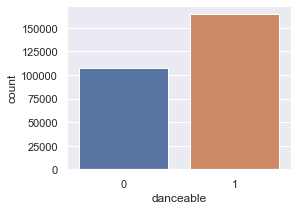

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 3))
sns.countplot(y_train["danceable"], ax = ax)

However, only `SMOTENC`, a vanilla SMOTE implementation for both categorical and continuous data, can be used given the presence of categorical features. But as was revealed from our feature importance chart, only one of the categorical features, `tim_4`, which indicates that a song has 4 beats per measure, was included among our 10 selected features, and has the least importance. So let's drop that feature to create our reduced feature matrix `Xr`.

In [31]:
Xr = X[sfdf[:-1]].copy()
Xr.head()

,acousticness,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,-0.771097,-0.923511,0.189653,-0.406136,-0.615265,0.600249,2.594201,-0.978872,-1.181590
1,-0.021569,-0.820553,-0.814268,-0.406136,-0.592036,0.002556,0.507205,0.200423,-0.522012
2,-0.462095,-0.209574,-0.666753,-0.405946,-0.545580,0.013206,0.266696,-1.002308,-1.225035
3,-0.898500,-0.462059,0.185556,-0.406136,-0.568808,0.833240,1.632166,-0.885787,-0.285038
4,-0.872513,-0.429865,0.021650,-0.406136,-0.382983,0.960603,0.313246,2.371132,-0.000669


We perform the usual 80/20 `train_test_split` to get our training and test partitions, using the same value for `random_state` to make the same data partition. `BorderlineSMOTE` will give us a modified `Xr_train` which we will call `Xm_train` and a modified `yr_train` which we will call `ym_train`.

**Remark.** This cell took around 2 minutes to run using `n_jobs = 2` on my machine. Results may vary.

In [33]:
# use same random state to get the same split of our training and test data
Xr_train, Xm_test, yr_train, ym_test = train_test_split(Xr, y, test_size = 0.2, random_state = 5)
# use constant seed for test purposes and balance classes equally. [try] to run on 
# two threads (not guaranteed) as multithreading not necessarily possible due to 
# python's (notorious?) global interpreter lock
sme = SMOTEENN(random_state = 11, n_jobs = 2)
# check shape pre-resample
print("Xr_train shape: {0}\tyr_train shape: {1}".format(Xr_train.shape, yr_train.shape))
# resample to equally balance classes; put ym_train back in DataFrame
Xm_train, ym_train = sme.fit_resample(Xr_train, yr_train)
ym_train = pd.DataFrame(ym_train, columns = ["danceable"])
# check shape post-resample
print("Xm_train shape: {0}\tym_train shape: {1}".format(Xm_train.shape, ym_train.shape))

Xr_train shape: (271880, 9)	yr_train shape: (271880, 1)


c:\users\d\start\python3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Xm_train shape: (188729, 9)	ym_train shape: (188729, 1)


We quickly check the class frequencies in our new modified response vector `ym_train`.

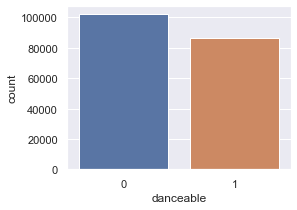

In [34]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 3))
sns.countplot(ym_train["danceable"], ax = ax)

Interestingly, `SMOTEENN` has more heavily weighted the 0 class. We now perform a 5-fold cross-validated grid search using `GridSearchCV` to tune the parameters of our decision tree to see how `SMOTEENN` may affect our training and test results. Again, we use accuracy as the scoring statistic.

**Remark.** This cell took around 4 minutes to run using `n_jobs = 2` on my machine. Results may vary.

In [35]:
# new decision tree classifier; again use entropy
dtc = DecisionTreeClassifier(criterion = "entropy")
# same parameter grid as in bb200_first_impressions.ipynb but with some added values
param_grid = {"min_samples_split": [2, 10, 20, 40], 
              "max_depth": [20, 25, 50, None], 
              "max_features": ["auto", None]}
# again use accuracy as scoring metric, 5 fold cross validation, and 2 core parallel
dtc_gscv = GridSearchCV(dtc, param_grid, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
dtc_gscv.fit(Xm_train, ym_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   49.4s
[Parallel(n_jobs=2)]: Done 160 out of 160 | elapsed:  2.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=2,
             param_grid={'max_depth': [20, 25, 50, None],
                         'max_features': ['auto', None],
                     

As usual, we check the average cross-validated training score (accuracy) and the test score of the best fitted tree.

In [36]:
# our best decision tree estimator
dtc_best = dtc_gscv.best_estimator_
print("5-fold CV grid accuracy:\t{0:.5f}\nbest tree grid accuracy:\t{1:.5f}\n"
      "best tree test accuracy:\t{2:.5f}"
      "".format(dtc_gscv.cv_results_["mean_test_score"].mean(), dtc_gscv.best_score_, 
                dtc_best.score(Xm_test, ym_test)))
# show our best decision tree estimator
dtc_best

5-fold CV grid accuracy:	0.91667
best tree grid accuracy:	0.92238
best tree test accuracy:	0.75171


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=25,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Looks like 75% test accuracy is about as far as we can go. We see that `SMOTEENN` leads to the model significantly overfitting on the training data without resulting in much improvement in the test data accuracy at all. Although it is disappointing that such a powerful technique is not helping our out-of-sample performance, it matches the intuition we had in `bb200_first_impressions.ipynb`, which was that none of the categorical and only a couple of the continuous features seemed to have much meaningful variation with our response column `danceability`.

We show our metrics, including misclassification rates, precision, AUC, confusion, ROC curve, and feature importances.

misclassification rate for 0:	0.21844
misclassification rate for 1:	0.26789
best tree test precision:	0.83614
best tree test AUC:		0.75683


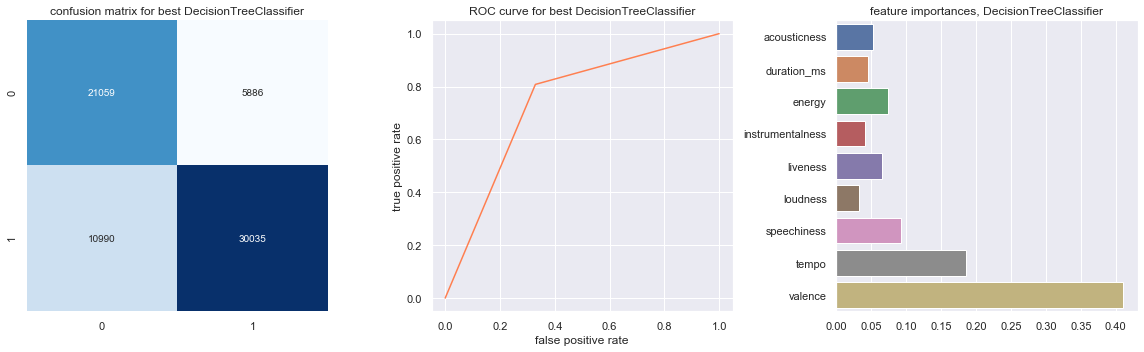

In [37]:
cmat = confusion_matrix(y_test, dtc_best.predict(Xm_test))
print("misclassification rate for 0:\t{0:.5f}\nmisclassification rate for 1:\t{1:.5f}"
      "".format(cmat[0][1] / sum(cmat[0]), cmat[1][0] / sum(cmat[1])))
# predicted values from test feature matrix
ym_test_pred = dtc_best.predict(Xm_test)
print("best tree test precision:\t{0:.5f}\nbest tree test AUC:\t\t{1:.5f}" 
      "".format(precision_score(ym_test, ym_test_pred), roc_auc_score(ym_test, ym_test_pred)))
# get fpr, tpr
ym_test_fpr, ym_test_tpr, thresholds = roc_curve(y_test, y_test_pred)
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
axs[0].set_title("confusion matrix for best DecisionTreeClassifier")
sns.heatmap(cmat, annot = True, cmap = "Blues", cbar = False, ax = axs[0], fmt = "d")
axs[1].set_title("ROC curve for best DecisionTreeClassifier")
axs[1].set_xlabel("false positive rate")
axs[1].set_ylabel("true positive rate")
sns.lineplot(ym_test_fpr, ym_test_tpr, color = "coral", ax = axs[1])
axs[2].set_title("feature importances, DecisionTreeClassifier")
sns.barplot(data = pd.DataFrame([dtc_best.feature_importances_],columns = Xm_test.columns), 
            ax = axs[2], orient = "h")
# supposed to prevent plots from overlapping but made the graphs more square
fig.tight_layout()

We see that compared to the decision tree trained in `bb200_first_impressions.ipynb` and the one we used for feature elimination, this tree has reduced `min_samples_split` from 40 to 2. Although the ROC curve looks similar to that of the tree used in this notebook for our feature elimination, our AUC is slightly higher (>1%) and our precision is up by almost 5%. Our misclassification rates are still high, but are more balanced. Interestingly, class 1 is being misclassified more, due to the edited nearest neighbors cleaning resulting in more synthetic/original class 0 compared to class 1 after `SMOTEENN` terminates. The improvement in precision and misclassification rates is welcome, despite the overfitting.

In the next section, we will move to try and increase our accuracy just a little bit more by using AdaBoost, first with stumps, then with real trees. Again, let's save our `Xm_train`, `Xm_test`, `ym_train`, and `ym_test` files, and then use `pickle` to save the `GridSearchCV` object and its embedded `DecisionTreeClassifier`. The reason I am saving the entire `GridSearchCV` object is for convenience, as it has all our CV statistics.

In [110]:
# save all files in the data directory; why did i not convert Xm_train to DataFrame?
pd.DataFrame(Xm_train, columns = Xr.columns).to_csv("./data/Xm_train.csv", index = False)
X_test.to_csv("./data/Xm_test.csv", index = False)
ym_train.to_csv("./data/ym_train.csv", index = False)
ym_test.to_csv("./data/ym_test.csv", index = False)
# pickle the dtc_gscv object to current directory
with open("./dtc_gscv.pickle", "wb") as dtc_gscv_file:
    pickle.dump(dtc_gscv, dtc_gscv_file)

### Boosting with AdaBoost: tree stumps

Before we consider training AdaBoost with our tuned decision tree, we will first establish a baseline for performance by using AdaBoost on decision tree stumps, i.e. trees that have `max_depth = 1`, the default base estimator used by the `AdaBoostClassifier`. We perform a 5-fold cross-validated grid search on resampled `Xm` and `ym`, varying the learning rate and the number of estimators to train unless an early stoppage is achieved.

**Remark.** We will use the default algorithm SAMME.R, as it is considered superior to SAMME.

**Remark.** We continue to use the same resampled `Xm_train` and `ym_train` data for convenience purposes.

**Remark.** This takes a longer time because we are fitting multiple sequences of tree stumps. With `n_jobs = 2`, it takes about 10 minutes on my machine.

In [88]:
# default base estimator is DecisionTreeClassifier(max_depth = 1), a stump
ada_stump = AdaBoostClassifier()
ada_stump_grid = {"n_estimators": [10, 20, 40, 50, 80], 
            "learning_rate": [0.01, 0.1, 1, 1.5]}
# again use accuracy as scoring metric, 5 fold cross validation, and 2 core parallel
ada_stump_gscv = GridSearchCV(ada_stump, ada_stump_grid, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
ada_stump_gscv.fit(Xm_train, ym_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  9.3min finished
c:\users\d\start\python3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=2,
             param_grid={'learning_rate': [0.01, 0.1, 1, 1.5],
                         'n_estimators': [10, 20, 40, 50, 80]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

As usual, we check the average cross-validated training score (accuracy) and the test score of the best boosted tree stump classifier.

In [89]:
# our best boosted tree stump classifer
ada_stump_best = ada_stump_gscv.best_estimator_
print("5-fold CV stump grid accuracy:\t{0:.5f}\nbest ada stump grid accuracy:\t{1:.5f}\n"
      "best ada stump test accuracy:\t{2:.5f}"
      "".format(ada_stump_gscv.cv_results_["mean_test_score"].mean(), ada_stump_gscv.best_score_, 
                ada_stump_best.score(Xm_test, ym_test)))
# show our best boosted tree stump estimator
ada_stump_best

5-fold CV stump grid accuracy:	0.86746
best ada stump grid accuracy:	0.91566
best ada stump test accuracy:	0.75670


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=80, random_state=None)

Our boosted stumps are clearly overfitting quite severely, with over an 86% average CV accuracy dropping to 75% on the test data. Thus, they provide about the same level of accuracy on the test set as a single decision tree while being more complex and much costlier to train.

Let us look at a few metrics. We show the misclassification rates, precision, AUC, ROC curve, and feature importances for our 80 boosted stumps.

misclassification rate for 0:	0.17302
misclassification rate for 1:	0.28946
best ada stump test precision:	0.86212
best ada stump test AUC:	0.76876


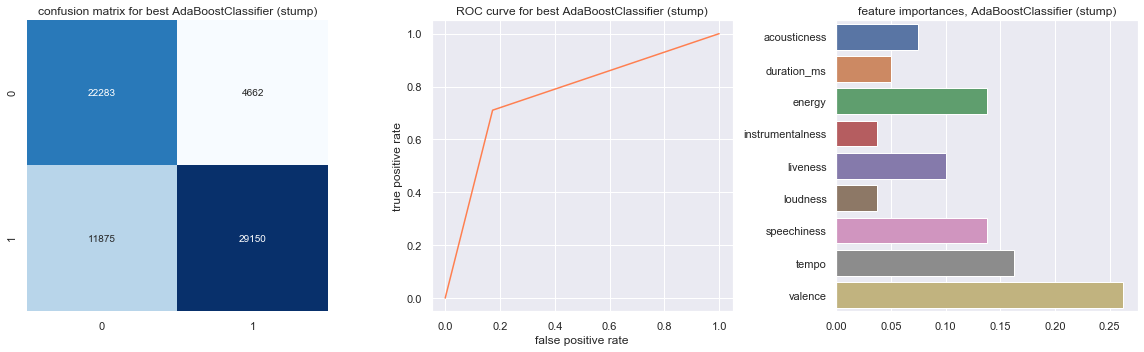

In [90]:
# our confusion matrix
ada_cmat = confusion_matrix(ym_test, ada_stump_best.predict(Xm_test))
print("misclassification rate for 0:\t{0:.5f}\nmisclassification rate for 1:\t{1:.5f}"
      "".format(ada_cmat[0][1] / sum(ada_cmat[0]), ada_cmat[1][0] / sum(ada_cmat[1])))
# predicted values from test feature matrix
ym_test_pred = ada_stump_best.predict(Xm_test)
print("best ada stump test precision:\t{0:.5f}\nbest ada stump test AUC:\t{1:.5f}" 
      "".format(precision_score(ym_test, ym_test_pred), roc_auc_score(ym_test, ym_test_pred)))
# get fpr, tpr
ym_test_fpr, ym_test_tpr, thresholds = roc_curve(ym_test, ym_test_pred)
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
axs[0].set_title("confusion matrix for best AdaBoostClassifier (stump)")
sns.heatmap(ada_cmat, annot = True, cmap = "Blues", cbar = False, ax = axs[0], fmt = "d")
axs[1].set_title("ROC curve for best AdaBoostClassifier (stump)")
axs[1].set_xlabel("false positive rate")
axs[1].set_ylabel("true positive rate")
sns.lineplot(ym_test_fpr, ym_test_tpr, color = "coral", ax = axs[1])
axs[2].set_title("feature importances, AdaBoostClassifier (stump)")
sns.barplot(data = pd.DataFrame([ada_stump_best.feature_importances_], columns = Xm_test.columns), 
            ax = axs[2], orient = "h")
fig.tight_layout()

The stumps are doing something interesting--they have reduced the misclassification rate for class 0 at the cost of class 1 being misclassified more often. We also see that the boosted stumps give a higher precision and slightly better AUC than the single decision tree. In terms of feature importance, the same features are again considered most important, but we see that the relative importance of the most important has been reduced, while the relative importance of the less important has been increased. This is a sign of our model overfitting more, but not to a ridiculous extent.

We now move on to created a "tuned" boosted classifier using decision trees as base learners, hoping for the best, and pickle the `GridSearchCV` object containing our boosted stumps. Again we do this because we want to preserve the cross validation statistics.

In [111]:
with open("./ada_stump_gscv.pickle", "wb") as ada_stump_gscv_file:
    pickle.dump(ada_stump_gscv, ada_stump_gscv_file)

### Boosting with AdaBoost: tuned decision tree

Instead of using stumps, we the base learner that we will use for our new `AdaBoostClassifier` will be a full decision tree, with `max_depth = 20`, slightly less than that of the single tree that we fit on our resampled `Xm_train` reduced feature matrix.

In [49]:
dtc_tuned = DecisionTreeClassifier(criterion = "entropy", max_depth = 20)
dtc_tuned

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

**Remark.** Now that we are fitting more complex trees, the amount of time this takes is definitely nontrivial. On my machine, with `n_jobs = 2`, I am at around 35 minutes. As usual, results may vary. Sadly longer model runtime doesn't always translate into a more accurate model.

In [50]:
# use the tuned decision tree as the base estimator
ada_tuned = AdaBoostClassifier(base_estimator = dtc_tuned)
# since each tree is pretty solid on its own, vary only number of trees
ada_tuned_grid = {"n_estimators": [10, 20, 40, 50]}
# again use accuracy as scoring metric, 5 fold cross validation, and 2 core parallel
ada_tuned_gscv = GridSearchCV(ada_tuned, ada_tuned_grid, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
ada_tuned_gscv.fit(Xm_train, ym_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed: 19.2min finished
c:\users\d\start\python3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                criterion='entropy',
                                                                                max_depth=20,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
                                                                               

As usual, we check the average cross-validated training score (accuracy) and the test score of the best boosted tree classifier.

In [51]:
# our best boosted tuned tree classifer
ada_tuned_best = ada_tuned_gscv.best_estimator_
print("5-fold CV tuned grid accuracy:\t{0:.5f}\nbest ada tuned grid accuracy:\t{1:.5f}\n"
      "best ada tuned test accuracy:\t{2:.5f}"
      "".format(ada_tuned_gscv.cv_results_["mean_test_score"].mean(), ada_tuned_gscv.best_score_, 
                ada_tuned_best.score(Xm_test, ym_test)))
# show our best boosted tree estimator
ada_tuned_best

5-fold CV tuned grid accuracy:	0.95082
best ada tuned grid accuracy:	0.95563
best ada tuned test accuracy:	0.77708


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=20,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                         

We trained a model for almost 40 minutes, and are still at <78% test accuracy. One can see the massive overfitting; on the training data, our accuracy is 95%. It is reasonable to think that without seriously devoting time to "creative" feature engineering, this is best we can do. For comparison with the single tree and boosted stumps, we show the misclassification rates, precision, AUC, and ROC curve of the boosted trees.

**Remark.** We also notice that with the boosted stumps, grid search continues to choose the additive model with the largest number of trees. The potential for boosted trees to overfit is quite terrifying, and suggests that using models that underfit more provides more marginal predictive power when boosting.

misclassification rate for 0:	0.19399
misclassification rate for 1:	0.24193
best ada tuned test precision:	0.85611
best ada tuned test AUC:	0.78204


c:\users\d\start\python3\lib\site-packages\sklearn\tree\tree.py:527: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


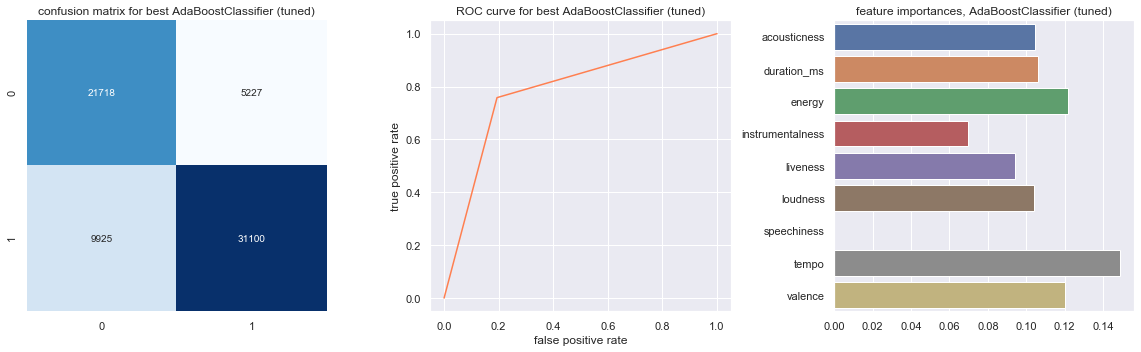

In [53]:
# our confusion matrix
adat_cmat = confusion_matrix(ym_test, ada_tuned_best.predict(Xm_test))
print("misclassification rate for 0:\t{0:.5f}\nmisclassification rate for 1:\t{1:.5f}"
      "".format(adat_cmat[0][1] / sum(adat_cmat[0]), adat_cmat[1][0] / sum(adat_cmat[1])))
# predicted values from test feature matrix
ym_test_pred = ada_tuned_best.predict(Xm_test)
print("best ada tuned test precision:\t{0:.5f}\nbest ada tuned test AUC:\t{1:.5f}" 
      "".format(precision_score(ym_test, ym_test_pred), roc_auc_score(ym_test, ym_test_pred)))
# get fpr, tpr
ym_test_fpr, ym_test_tpr, thresholds = roc_curve(ym_test, ym_test_pred)
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
axs[0].set_title("confusion matrix for best AdaBoostClassifier (tuned)")
sns.heatmap(adat_cmat, annot = True, cmap = "Blues", cbar = False, ax = axs[0], fmt = "d")
axs[1].set_title("ROC curve for best AdaBoostClassifier (tuned)")
axs[1].set_xlabel("false positive rate")
axs[1].set_ylabel("true positive rate")
sns.lineplot(ym_test_fpr, ym_test_tpr, color = "coral", ax = axs[1])
axs[2].set_title("feature importances, AdaBoostClassifier (tuned)")
sns.barplot(data = pd.DataFrame([ada_tuned_best.feature_importances_], columns = Xm_test.columns), 
            ax = axs[2], orient = "h")
fig.tight_layout()

Our misclassification rates are a little more balanced this time, but of course still high. Interestingly, the boosted trees have slightly less precision than the boosted stumps, but do have a slightly higher AUC and better ROC curve than both the boosted stumps and the single decision tree. However, it really does seem that without increasing the number of trees in our additive model, our accuracy is more or less bounded above by 80%. Also, it looks like speechiness was never considered as a feature to base a split on, as it has a NaN value.

We try one more thing to see if tree boosting can still be profitable, at the cost of complexity. Again we save the `GridSearchCV` object.

In [112]:
with open("./ada_tuned_gscv.pickle", "wb") as ada_tuned_gscv_file:
    pickle.dump(ada_tuned_gscv, ada_tuned_gscv_file)

### Boosting with AdaBoost: increasing `n_estimators`

Since we have had some marginal return by using a more complex base estimator, and we see that if given multiple values for the maximum number of trees that may be trained, grid search continues to prefer training as many trees as possible. We see that as our training accuracy increases through overfitting, we are still experiencing marginal gains in real test accuracy.
So let's go wild, one last time, to fit up to 150 decision trees.

**Remark.** Be patient with this one. On my machine, with `n_jobs = 2`, it takes more than an hour, even though it reports ~45 minutes. Oof.

In [80]:
# extended AdaBoostClassifier
ada_ext = AdaBoostClassifier(base_estimator = dtc_tuned)
# focus on training the maximum number of trees possible
ada_ext_grid = {"n_estimators": [100, 150]}
# again use accuracy as scoring metric, 5 fold cross validation, and 2 core parallel
ada_ext_gscv = GridSearchCV(ada_ext, ada_ext_grid, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
ada_ext_gscv.fit(Xm_train, ym_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 39.4min finished
c:\users\d\start\python3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                criterion='entropy',
                                                                                max_depth=20,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
                                                                               

As usual, we check the average cross-validated training score (accuracy) and the test score of the best extended boosted tree classifier.

**Remark.** Takes a couple seconds to run since we are running 150 trees sequentially.

In [81]:
# our best boosted extended tree classifer
ada_ext_best = ada_ext_gscv.best_estimator_
print("5-fold CV ext grid accuracy:\t{0:.5f}\nbest ada ext grid accuracy:\t{1:.5f}\n"
      "best ada ext test accuracy:\t{2:.5f}"
      "".format(ada_ext_gscv.cv_results_["mean_test_score"].mean(), ada_ext_gscv.best_score_, 
                ada_ext_best.score(Xm_test, ym_test)))
# show our best extended boosted tree estimator
ada_ext_best

5-fold CV ext grid accuracy:	0.95866
best ada ext grid accuracy:	0.95886
best ada ext test accuracy:	0.78049


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=20,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                         

Here we train a model for more than an hour, and with an additional 100 trees of depth 10 and an additional 20 or so minutes of training, we increase training and test accuracies by less than 1 percent each. This is a good example of decreasing marginal return. Again, the model massively overfits on the training data, with almost 96% cross-validated training accuracy, but with again less than 80% accuracy on the test data. For comparison with the single tree, the 80 boosted stumps, and the 50 boosted trees, we show the misclassification rates, precision, AUC, and ROC curve of the 150 boosted trees.

misclassification rate for 0:	0.19391
misclassification rate for 1:	0.23632
best ada ext test precision:	0.85706
best ada ext test AUC:		0.78488


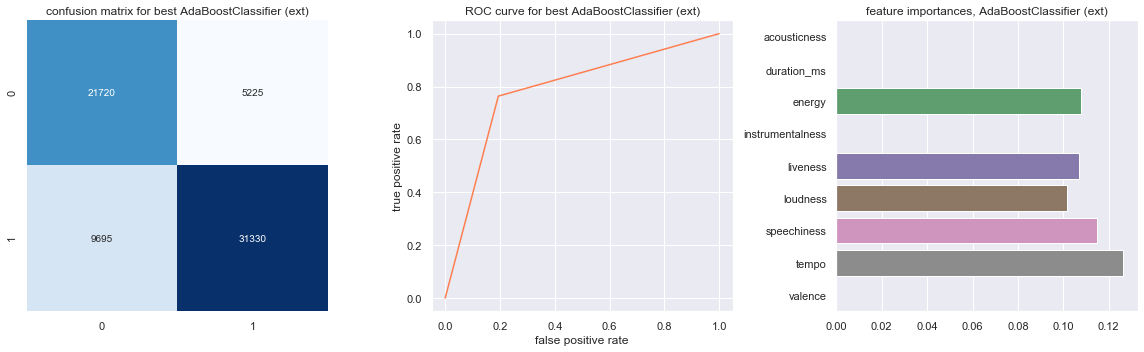

In [82]:
# our confusion matrix
adae_cmat = confusion_matrix(ym_test, ada_ext_best.predict(Xm_test))
print("misclassification rate for 0:\t{0:.5f}\nmisclassification rate for 1:\t{1:.5f}"
      "".format(adae_cmat[0][1] / sum(adae_cmat[0]), adae_cmat[1][0] / sum(adae_cmat[1])))
# predicted values from test feature matrix
ym_test_pred = ada_ext_best.predict(Xm_test)
print("best ada ext test precision:\t{0:.5f}\nbest ada ext test AUC:\t\t{1:.5f}" 
      "".format(precision_score(ym_test, ym_test_pred), roc_auc_score(ym_test, ym_test_pred)))
# get fpr, tpr
ym_test_fpr, ym_test_tpr, thresholds = roc_curve(ym_test, ym_test_pred)
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
axs[0].set_title("confusion matrix for best AdaBoostClassifier (ext)")
sns.heatmap(adae_cmat, annot = True, cmap = "Blues", cbar = False, ax = axs[0], fmt = "d")
axs[1].set_title("ROC curve for best AdaBoostClassifier (ext)")
axs[1].set_xlabel("false positive rate")
axs[1].set_ylabel("true positive rate")
sns.lineplot(ym_test_fpr, ym_test_tpr, color = "coral", ax = axs[1])
axs[2].set_title("feature importances, AdaBoostClassifier (ext)")
sns.barplot(data = pd.DataFrame([ada_ext_best.feature_importances_], columns = Xm_test.columns), 
            ax = axs[2], orient = "h")
fig.tight_layout()

Adding 100 extra trees to our model only ever so slightly decreases misclassification rates, increases precision, and increases AUC. Materially, performance of the 150 boosted trees is more or less the same as the performance of the 50 boosted trees, at the cost of an extra 20 minutes of waiting. Again, our test accuracy is still below the 80% upper bound, which is disappointing considering how much extra computational time has been invested.

We will stop here with our consideration of particular models; we could say try to go for a feedforward neural network or gradient tree boosting, but our purpose in using tree-based models was to compute feature importances, which we will now analyze. Again, we save the `GridSearchCV` object.

In [113]:
with open("./ada_ext_gscv.pickle", "wb") as ada_ext_gscv_file:
    pickle.dump(ada_ext_gscv, ada_ext_gscv_file)

### Interpreting feature importances

The great thing about tree-based classifiers such as decision trees and our boosting models is that they compute feature importances, so beyond the selection of features through a feature elimination method such as `RFECV`, we can get relative "importances" of each selected feature. Below, using the `feature_importances_` property of the tree-based classifiers, we take a look at exactly how the 9 continuous features we selected rank.

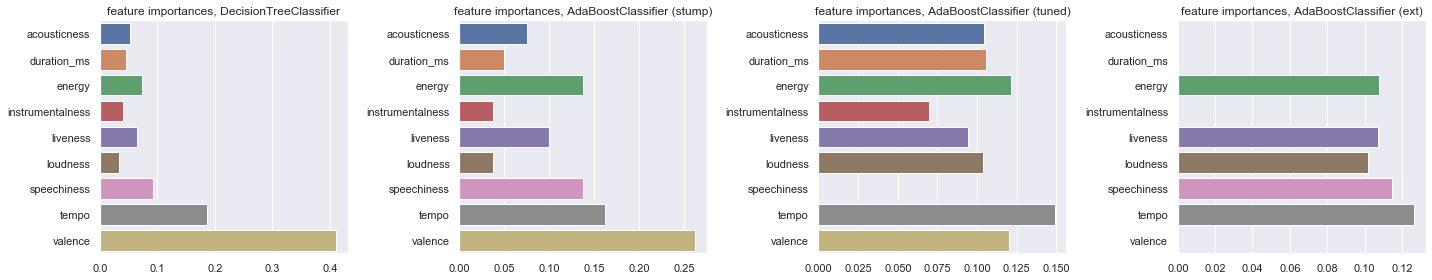

In [92]:
# feature importances for the single decision tree, boosted stumps, 50 trees, and 150 trees
dtc_best_fis = dtc_best.feature_importances_
ada_stump_fis = ada_stump_best.feature_importances_
ada_tuned_fis = ada_tuned_best.feature_importances_
ada_ext_fis = ada_ext_best.feature_importances_
# list of feature importances
feat_imps = [dtc_best_fis, ada_stump_fis, ada_tuned_fis, ada_ext_fis]
# create bar plots for each of the models
# axis titles
ax_titles = ["feature importances, DecisionTreeClassifier", 
             "feature importances, AdaBoostClassifier (stump)", 
             "feature importances, AdaBoostClassifier (tuned)", 
             "feature importances, AdaBoostClassifier (ext)"]
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 4))
for feat_imp, ax_title, ax in zip(feat_imps, ax_titles, axs):
    sns.barplot(data = pd.DataFrame([feat_imp], columns = Xm_test.columns), 
                ax = ax, orient = "h")
    ax.set_title(ax_title)
fig.tight_layout()

We see an interesting pattern in that follows how much we are overfitting our models. The single decision tree seems to weight `valence` the highest, followed by `tempo`. The other few features are not all even; for example, `energy` is a higher than `instrumentalness`. The 80 boosted stumps still place high importance on `valence`, but less so, holding `tempo`, `speechiness`, and `energy` to be more important than before. Other features have increases in importance as well. The 50 boosted trees with `max_depth = 20` start to hold a lot of features as having similar importance, although `instrumentalness` is still considered relatively unimportant. `tempo` and `valence` are stil considered highly important, but `loudness` has all of a sudden spiked in importance, `liveness` and `duration_ms` have also both become very important, and `speechiness` is now `nan`. For the 150 boosted trees with `max_depth = 20`, the model actually has `nan` values for several of the features, and holds the remaining features to be of the relatively same level of importance.

This pattern seems to follow each model's ability to overfit the cross-validated, resampled, training data. `valence` was considered the most important feature, but then as we used more and more powerful models with greater ability to overfit the training data, other features began to rise in importance, and then all the features ended up being close to the same in importance once the model began modeling noise. The 150 tree model is concerning, as it looks like the model settled on choosing simply only a few of the features, of which only `tempo` was considered important from the beginning. The `nan` values arise from numerical errors in the `sklearn` package; it may be that these features are of infinite importance and the `numpy` float has overflowed.

Let's return to our original training data, with feature matrix `X_train` and response `y_train`. It looks like the combination of resampling, feature elimination, and tree boosting is only causing us to overfit and not produce any extra predictive power, which is the disappointing reality.

### Boosting with AdaBoost: no feature selection, no re-sampling, stumps

We will try two different boosted tree models on the original `X_train` and `y_train` data, namely the 80 boosted stumps and the 50 boosted trees with `max_depth = 20`. We will then check feature importances immediately to get a sense of what seems to be predictive and what isn't.

First, we try fitting the 80 boosted stumps. This takes about 2 minutes on my machine with `n_jobs = 2`.

In [85]:
# default base estimator is DecisionTreeClassifier(max_depth = 1), a stump
ada_fstump = AdaBoostClassifier()
ada_fstump_grid = {"n_estimators": [80]}
# again use accuracy as scoring metric, 5 fold cross validation, and 2 core parallel
ada_fstump_gscv = GridSearchCV(ada_stump, ada_fstump_grid, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
ada_fstump_gscv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.6min finished
c:\users\d\start\python3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=2, param_grid={'n_estimators': [80]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

As usual, we check the average cross-validated training score (accuracy) and the test score of the best boosted tree stump classifier.

In [86]:
# our best full boosted tree stump classifer
ada_fstump_best = ada_fstump_gscv.best_estimator_
print("5-fold CV fstump grid accuracy:\t{0:.5f}\nbest ada fstump grid accuracy:\t{1:.5f}\n"
      "best ada fstump test accuracy:\t{2:.5f}"
      "".format(ada_fstump_gscv.cv_results_["mean_test_score"].mean(), ada_fstump_gscv.best_score_, 
                ada_fstump_best.score(X_test, y_test)))
# show our best full boosted tree stump estimator
ada_fstump_best

5-fold CV fstump grid accuracy:	0.78460
best ada fstump grid accuracy:	0.78460
best ada fstump test accuracy:	0.78583


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=80, random_state=None)

Although not out of the expectation, this is still surprising. Running 80 stumps on the whole training feature matrix `X_train` has resolved our overfitting problem; our training and test accuracy scores are very similar, and better than the 150 trees trained on `Xm_train`, the reduced and re-sampled training feature matrix. We show the precision, AUC, misclassification rates, and the ROC curve for our 80 boosted stumps.

misclassification rate for 0:	0.31639
misclassification rate for 1:	0.14703
best ada stump test precision:	0.80410
best ada stump test AUC:	0.76829


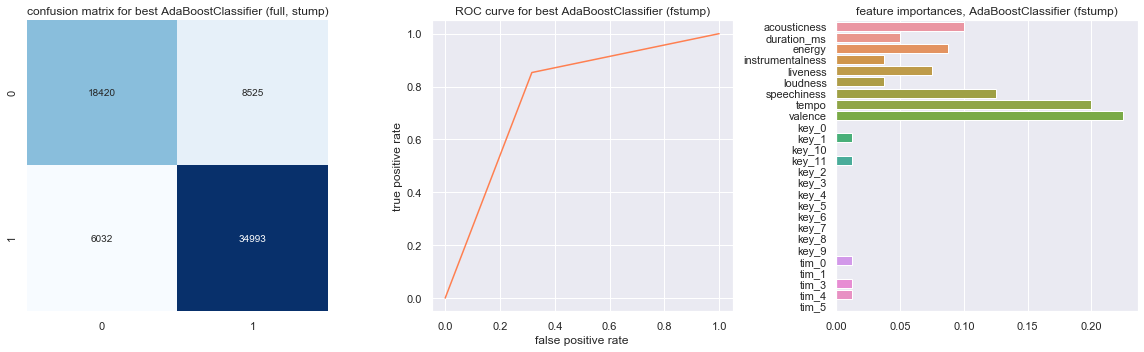

In [87]:
# our confusion matrix
ada_fcmat = confusion_matrix(y_test, ada_fstump_best.predict(X_test))
print("misclassification rate for 0:\t{0:.5f}\nmisclassification rate for 1:\t{1:.5f}"
      "".format(ada_fcmat[0][1] / sum(ada_fcmat[0]), ada_fcmat[1][0] / sum(ada_fcmat[1])))
# predicted values from test feature matrix
y_test_pred = ada_fstump_best.predict(X_test)
print("best ada stump test precision:\t{0:.5f}\nbest ada stump test AUC:\t{1:.5f}" 
      "".format(precision_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred)))
# get fpr, tpr
y_test_fpr, y_test_tpr, thresholds = roc_curve(y_test, y_test_pred)
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
axs[0].set_title("confusion matrix for best AdaBoostClassifier (full, stump)")
sns.heatmap(ada_fcmat, annot = True, cmap = "Blues", cbar = False, ax = axs[0], fmt = "d")
axs[1].set_title("ROC curve for best AdaBoostClassifier (fstump)")
axs[1].set_xlabel("false positive rate")
axs[1].set_ylabel("true positive rate")
sns.lineplot(y_test_fpr, y_test_tpr, color = "coral", ax = axs[1])
axs[2].set_title("feature importances, AdaBoostClassifier (fstump)")
sns.barplot(data = pd.DataFrame([ada_fstump_best.feature_importances_], columns = X.columns), 
            ax = axs[2], orient = "h")
# supposed to prevent plots from overlapping but made the graphs more square
fig.tight_layout()

Unfortunately, our misclassification rate of 0 has spiked yet again, due to the imbalance within classes, and our precision has fallen to 80%, despite an increase in AUC. Essentially, running 80 stumps on the full `X_train` produces a learner that has higher accuracy and slightly better characteristics than the original decision tree we ran on the pre-`SMOTEENN` reduce feature matrix. This is not bad; theoretically, if we add full trees, we should do better. Interestingly, a few of the time signatures and a couple of keys are flagged as having more importance than was found by the single decision tree.

As usual, we save the entire `GridSearchCV` object to preserve the cross validation statistics along with our model.

In [114]:
with open("./ada_fstump_gscv.pickle", "wb") as ada_fstump_gscv_file:
    pickle.dump(ada_fstump_gscv, ada_fstump_gscv_file)

### Key takeaways

Feature elimination led to a single decision tree overfitting on the training data. Although `SMOTEENN` does ameliorate the very high misclassification rate for class 0, it decreases it at the expense of increasing the misclassification rate for class 1. However, overall model precision is increased, and the ROC curve is shifted more to the left to reflect that. As we train models harder and harder on the data, we seem to reach a limit in the tradeoff between overall accuracy and model precision. And the more we overfit the model, the less particular features matter, as the feature importances asll begin to converge to similar levels.

Surprisingly, by fitting our 80 stumps on the full feature matrix, without any resampling or feature selection, we are able to achieve a slightly higher default accuracy than the 150 boosted trees on the resampled, reduced feature matrix. But, as with the other models fit on the entire feature matrix, we suffer a loss in precision and experience a significantly high misclassification rate for the 0 class. Fitting full boosted trees on the full feature matrix is now the next step.